In [12]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [17]:
class AutoRegressiveMLP(nn.Module):

    def __init__(self, state_size, hidden_size):
        super().__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size
        self.mlp = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, state_size)
        )

    def iterate_once(self, x):
        return self.mlp(x)
    
    def forward(self, x, n_iter):
        for _ in range(n_iter):
            x = self.iterate_once(x)
        return x
    
    

class BasicRNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        # output dims are (seq_len, batch, num_directions * hidden_size)
        return output[-1, ...]

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [23]:
# Simulate the lorenz system to generate data
def lorenz(x, y, z, s=10, r=28, b=2.667):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

dt = 0.01
num_steps = 100

xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

xs[0], ys[0], zs[0] = (0., 1., 1.05)

for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


In [33]:
model1 = AutoRegressiveMLP(3, 16)

# Convert the data to torch tensors
data = torch.tensor(np.vstack([xs, ys, zs]).T, dtype=torch.float32)

# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

all_losses = []
n_iter = 1000
for i in range(n_iter):
    optimizer.zero_grad()
    output = model1(data[:-1, :], 100)
    loss = criterion(output, data[1:, :])
    loss.backward()
    optimizer.step()
    all_losses.append(loss.item())

    if i % 100 == 0:
        print(f"Iteration {i}, loss: {loss.item()}")

Iteration 0, loss: 333.3638610839844
Iteration 100, loss: 244.08346557617188
Iteration 200, loss: 204.66827392578125
Iteration 300, loss: 144.39183044433594
Iteration 400, loss: 142.29037475585938
Iteration 500, loss: 110.84786224365234
Iteration 600, loss: 106.89539337158203
Iteration 700, loss: 102.91163635253906
Iteration 800, loss: 98.984130859375
Iteration 900, loss: 95.51801300048828


In [36]:
data.shape

torch.Size([101, 3])

In [34]:
output.shape

torch.Size([100, 3])

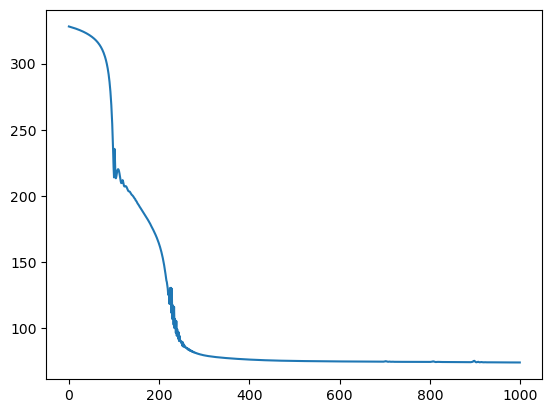

In [32]:
plt.plot(all_losses)